## **Step2: LLM**
- Splitted the 15k tokenized dataset into 80/20
- Used Hugging Face Trainer
- Used distilbert-base-uncased pretained model

In [1]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import optuna

### **Deleting empty entries**
- When running the trainer for the first time we noticed an error
- The error was "ValueError: expected sequence of length 512 at dim 1 (got 0)"
- So we filtered those empty reviews before training

In [ ]:
df = pd.read_csv('goodreads_15k_english_tokenized.csv')

original_length = len(df)

# Step 2: Filter out rows where `input_ids` or `attention_mask` are empty
df = df[df['input_ids'].apply(lambda x: len(eval(x)) > 0)]
df = df[df['attention_mask'].apply(lambda x: len(eval(x)) > 0)]

filtered_length = len(df)
deleted_entries = original_length - filtered_length
print(f"Number of entries deleted because they were empty: {deleted_entries}")

df.to_csv('goodreads_15k_english_tokenized_filtered.csv', index=False)

In [2]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    
    # Manually calculate Mean Squared Error (MSE)
    mse = np.mean((predictions - labels) ** 2)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    
    # Pseudo-Accuracy: Round predictions to nearest integer and clip to valid range (1-5)
    rounded_predictions = np.round(predictions).clip(1, 5)
    accuracy = accuracy_score(labels, rounded_predictions)
    
    return {
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2,
        "Pseudo-Accuracy": accuracy
    }

### **LLM Fine Tuning - Optuna**
- We will use optuna tool for hyperparameter searching
- Just 2.5k entries per genre for the Fine Tuning part (best params will be ran in the full ds later)
- We will use GPU to make the process faster
- By simply adding ".to("cuda")"
- CPU: 12hrs -> GPU: 12mins (in a 50k entries dataset)

In [3]:
# Load the full dataset
file_path = 'goodreads_15k_english_tokenized_filtered.csv'
df = pd.read_csv(file_path)

# Sample 2,500 entries per genre
sample_size = 2500
unique_genres = df['genres'].unique()
sampled_data = []

for genre in unique_genres:
    genre_subset = df[df['genres'] == genre]
    if len(genre_subset) >= sample_size:
        genre_sample = genre_subset.sample(n=sample_size, random_state=42)
    else:
        genre_sample = genre_subset
    sampled_data.append(genre_sample)

small_sample_df = pd.concat(sampled_data, ignore_index=True)
small_sample_dataset = Dataset.from_pandas(small_sample_df)

# Define the function to adjust the dataset for regression
def convert_to_tensor(examples):
    return {
        'input_ids': torch.tensor(eval(examples['input_ids']), dtype=torch.long),
        'attention_mask': torch.tensor(eval(examples['attention_mask']), dtype=torch.long),
        'labels': torch.tensor(examples['rating'], dtype=torch.float)
    }

train_val_test_split = small_sample_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test_split['train']
val_test_split = train_val_test_split['test'].train_test_split(test_size=0.5, seed=42)
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

train_dataset = train_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])
val_dataset = val_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])
test_dataset = test_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [4]:
def objective(trial):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)
    gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 1, 4)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 1.0)
    adam_beta1 = trial.suggest_float("adam_beta1", 0.85, 0.95)
    adam_beta2 = trial.suggest_float("adam_beta2", 0.98, 0.999)
    fp16 = trial.suggest_categorical("fp16", [True, False])

    # Initialize model for regression
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1).to("cuda")

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=1,
        weight_decay=weight_decay,
        gradient_accumulation_steps=gradient_accumulation_steps,
        max_grad_norm=max_grad_norm,
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        fp16=fp16,
        save_strategy="epoch",
        logging_dir="./logs",
        load_best_model_at_end=True,
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train and evaluate
    trainer.train()
    eval_result = trainer.evaluate()
    
    # Store model in the trial's user attributes to retrieve it later
    trial.set_user_attr("model", model)
    
    return eval_result["eval_loss"]

In [5]:
# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Best hyperparameters:", study.best_params)

[I 2024-11-02 22:32:03,565] A new study created in memory with name: no-name-5e0cde36-17d9-4e82-ad91-aa1890fad838
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_c

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 1.6231, 'grad_norm': 18.232452392578125, 'learning_rate': 9.85226850554304e-06, 'epoch': 0.4}
{'loss': 0.9995, 'grad_norm': 16.850675582885742, 'learning_rate': 3.318933952795666e-06, 'epoch': 0.8}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0077018737792969, 'eval_MSE': 1.0077018737792969, 'eval_MAE': 0.6943835020065308, 'eval_R2 Score': 0.35421282052993774, 'eval_Pseudo-Accuracy': 0.4932, 'eval_runtime': 7.0342, 'eval_samples_per_second': 355.409, 'eval_steps_per_second': 44.497, 'epoch': 1.0}
{'train_runtime': 198.6939, 'train_samples_per_second': 100.657, 'train_steps_per_second': 6.291, 'train_loss': 1.2222165649414063, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:35:32,660] Trial 0 finished with value: 1.0077018737792969 and parameters: {'learning_rate': 1.6333336381868436e-05, 'batch_size': 16, 'weight_decay': 0.008033590077146486, 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.5356776731497133, 'adam_beta1': 0.8756968768489233, 'adam_beta2': 0.9907722218527304, 'fp16': True}. Best is trial 0 with value: 1.0077018737792969.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0633667707443237, 'eval_MSE': 1.0633667707443237, 'eval_MAE': 0.7390550971031189, 'eval_R2 Score': 0.3185398578643799, 'eval_Pseudo-Accuracy': 0.4644, 'eval_runtime': 7.047, 'eval_samples_per_second': 354.763, 'eval_steps_per_second': 44.416, 'epoch': 1.0}
{'train_runtime': 182.7079, 'train_samples_per_second': 109.464, 'train_steps_per_second': 1.708, 'train_loss': 1.8110592181865985, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:38:42,878] Trial 1 finished with value: 1.0633667707443237 and parameters: {'learning_rate': 1.4994750134709102e-05, 'batch_size': 16, 'weight_decay': 0.0006443163255965891, 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.6188377733737471, 'adam_beta1': 0.9037882032232003, 'adam_beta2': 0.9977906232424748, 'fp16': True}. Best is trial 0 with value: 1.0077018737792969.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 1.7669, 'grad_norm': 22.771835327148438, 'learning_rate': 7.446888518803957e-06, 'epoch': 0.4}
{'loss': 1.023, 'grad_norm': 18.589927673339844, 'learning_rate': 2.5086335328596886e-06, 'epoch': 0.8}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0265125036239624, 'eval_MSE': 1.0265125036239624, 'eval_MAE': 0.7063410878181458, 'eval_R2 Score': 0.3421580195426941, 'eval_Pseudo-Accuracy': 0.478, 'eval_runtime': 7.064, 'eval_samples_per_second': 353.908, 'eval_steps_per_second': 44.309, 'epoch': 1.0}
{'train_runtime': 198.4558, 'train_samples_per_second': 100.778, 'train_steps_per_second': 6.299, 'train_loss': 1.2945676513671875, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:42:09,079] Trial 2 finished with value: 1.0265125036239624 and parameters: {'learning_rate': 1.2345637464860672e-05, 'batch_size': 16, 'weight_decay': 0.0005001398655122933, 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.7085004878066854, 'adam_beta1': 0.8924511129479792, 'adam_beta2': 0.9818442746930047, 'fp16': False}. Best is trial 0 with value: 1.0077018737792969.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 1.6828, 'grad_norm': 9.02029037475586, 'learning_rate': 1.5156541949943913e-05, 'epoch': 0.2}
{'loss': 1.0169, 'grad_norm': 12.663420677185059, 'learning_rate': 1.1374969607143537e-05, 'epoch': 0.4}
{'loss': 0.9788, 'grad_norm': 13.102641105651855, 'learning_rate': 7.593397264343159e-06, 'epoch': 0.6}
{'loss': 0.9519, 'grad_norm': 31.94923973083496, 'learning_rate': 3.8118249215427806e-06, 'epoch': 0.8}
{'loss': 0.8487, 'grad_norm': 35.29822540283203, 'learning_rate': 3.7815723428003777e-08, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.9684329032897949, 'eval_MSE': 0.9684329032897949, 'eval_MAE': 0.6748780012130737, 'eval_R2 Score': 0.37937837839126587, 'eval_Pseudo-Accuracy': 0.5072, 'eval_runtime': 7.0891, 'eval_samples_per_second': 352.657, 'eval_steps_per_second': 44.153, 'epoch': 1.0}
{'train_runtime': 217.3866, 'train_samples_per_second': 92.002, 'train_steps_per_second': 11.5, 'train_loss': 1.0958080810546875, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:45:54,199] Trial 3 finished with value: 0.9684329032897949 and parameters: {'learning_rate': 1.890786171400189e-05, 'batch_size': 8, 'weight_decay': 0.000707805821402821, 'gradient_accumulation_steps': 1, 'max_grad_norm': 0.5364404114188963, 'adam_beta1': 0.9046655009641287, 'adam_beta2': 0.9937396295638947, 'fp16': False}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0442233085632324, 'eval_MSE': 1.0442233085632324, 'eval_MAE': 0.7277039289474487, 'eval_R2 Score': 0.33080798387527466, 'eval_Pseudo-Accuracy': 0.4644, 'eval_runtime': 7.1561, 'eval_samples_per_second': 349.354, 'eval_steps_per_second': 43.739, 'epoch': 1.0}
{'train_runtime': 184.2464, 'train_samples_per_second': 108.55, 'train_steps_per_second': 1.693, 'train_loss': 1.6315928728152544, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:49:06,057] Trial 4 finished with value: 1.0442233085632324 and parameters: {'learning_rate': 2.349161345563243e-05, 'batch_size': 16, 'weight_decay': 0.0004299844200647237, 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.6073943028219319, 'adam_beta1': 0.9312332224480098, 'adam_beta2': 0.9861014353838427, 'fp16': True}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0921770334243774, 'eval_MSE': 1.092177152633667, 'eval_MAE': 0.7508453130722046, 'eval_R2 Score': 0.3000767230987549, 'eval_Pseudo-Accuracy': 0.4596, 'eval_runtime': 7.1853, 'eval_samples_per_second': 347.935, 'eval_steps_per_second': 43.561, 'epoch': 1.0}
{'train_runtime': 183.8006, 'train_samples_per_second': 108.814, 'train_steps_per_second': 0.849, 'train_loss': 2.0642496744791665, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:52:17,535] Trial 5 finished with value: 1.0921770334243774 and parameters: {'learning_rate': 2.579868260405559e-05, 'batch_size': 32, 'weight_decay': 0.0005062558477311894, 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.8179601915313124, 'adam_beta1': 0.9268689096918085, 'adam_beta2': 0.9940259465434544, 'fp16': True}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0088127851486206, 'eval_MSE': 1.0088127851486206, 'eval_MAE': 0.7091414332389832, 'eval_R2 Score': 0.3535009026527405, 'eval_Pseudo-Accuracy': 0.4812, 'eval_runtime': 7.2149, 'eval_samples_per_second': 346.504, 'eval_steps_per_second': 43.382, 'epoch': 1.0}
{'train_runtime': 186.6689, 'train_samples_per_second': 107.142, 'train_steps_per_second': 2.229, 'train_loss': 1.3923184321476862, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:55:31,919] Trial 6 finished with value: 1.0088127851486206 and parameters: {'learning_rate': 2.872652524098916e-05, 'batch_size': 16, 'weight_decay': 0.00027215085426038387, 'gradient_accumulation_steps': 3, 'max_grad_norm': 0.808367736431004, 'adam_beta1': 0.8944872327224975, 'adam_beta2': 0.9813212348992457, 'fp16': False}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0593502521514893, 'eval_MSE': 1.0593502521514893, 'eval_MAE': 0.7379910349845886, 'eval_R2 Score': 0.3211139440536499, 'eval_Pseudo-Accuracy': 0.4568, 'eval_runtime': 7.1944, 'eval_samples_per_second': 347.492, 'eval_steps_per_second': 43.506, 'epoch': 1.0}
{'train_runtime': 183.9584, 'train_samples_per_second': 108.72, 'train_steps_per_second': 0.848, 'train_loss': 1.9009931515424678, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 22:58:43,599] Trial 7 finished with value: 1.0593502521514893 and parameters: {'learning_rate': 3.144948286097239e-05, 'batch_size': 32, 'weight_decay': 0.00013888887666004587, 'gradient_accumulation_steps': 4, 'max_grad_norm': 0.5069729625955427, 'adam_beta1': 0.9029819643527071, 'adam_beta2': 0.9845103599568569, 'fp16': False}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 1.0256092548370361, 'eval_MSE': 1.0256091356277466, 'eval_MAE': 0.7154677510261536, 'eval_R2 Score': 0.3427368998527527, 'eval_Pseudo-Accuracy': 0.4928, 'eval_runtime': 7.1981, 'eval_samples_per_second': 347.315, 'eval_steps_per_second': 43.484, 'epoch': 1.0}
{'train_runtime': 186.7971, 'train_samples_per_second': 107.068, 'train_steps_per_second': 1.67, 'train_loss': 1.4789995046762319, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 23:01:58,131] Trial 8 finished with value: 1.0256092548370361 and parameters: {'learning_rate': 3.858605937732559e-05, 'batch_size': 32, 'weight_decay': 0.006480529507329442, 'gradient_accumulation_steps': 2, 'max_grad_norm': 0.9975408363200495, 'adam_beta1': 0.9416039131296561, 'adam_beta2': 0.9891389779763595, 'fp16': False}. Best is trial 3 with value: 0.9684329032897949.
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)
C:\Users\danie\AppData\Local\Temp\ipykernel_36500\2839455619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

  0%|          | 0/833 [00:00<?, ?it/s]

{'loss': 1.316, 'grad_norm': 13.873703002929688, 'learning_rate': 1.5238382215746085e-05, 'epoch': 0.6}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.9549251794815063, 'eval_MSE': 0.9549251794815063, 'eval_MAE': 0.6764657497406006, 'eval_R2 Score': 0.3880348205566406, 'eval_Pseudo-Accuracy': 0.5068, 'eval_runtime': 7.2206, 'eval_samples_per_second': 346.232, 'eval_steps_per_second': 43.348, 'epoch': 1.0}
{'train_runtime': 192.0285, 'train_samples_per_second': 104.151, 'train_steps_per_second': 4.338, 'train_loss': 1.152650464482668, 'epoch': 1.0}


  0%|          | 0/313 [00:00<?, ?it/s]

[I 2024-11-02 23:05:17,911] Trial 9 finished with value: 0.9549251794815063 and parameters: {'learning_rate': 3.789126085288504e-05, 'batch_size': 8, 'weight_decay': 0.00012004763149331018, 'gradient_accumulation_steps': 3, 'max_grad_norm': 0.6165896443082339, 'adam_beta1': 0.8849650337664438, 'adam_beta2': 0.99587105031126, 'fp16': True}. Best is trial 9 with value: 0.9549251794815063.


Best hyperparameters: {'learning_rate': 3.789126085288504e-05, 'batch_size': 8, 'weight_decay': 0.00012004763149331018, 'gradient_accumulation_steps': 3, 'max_grad_norm': 0.6165896443082339, 'adam_beta1': 0.8849650337664438, 'adam_beta2': 0.99587105031126, 'fp16': True}


### **Best hyperparameters: {'learning_rate': 3.789126085288504e-05, 'batch_size': 8, 'weight_decay': 0.00012004763149331018, 'gradient_accumulation_steps': 3, 'max_grad_norm': 0.6165896443082339, 'adam_beta1': 0.8849650337664438, 'adam_beta2': 0.99587105031126, 'fp16': True}**

In [6]:
# Load tokenized dataset
df = pd.read_csv('goodreads_15k_english_tokenized_filtered.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['input_ids', 'attention_mask', 'rating']])
val_dataset = Dataset.from_pandas(val_df[['input_ids', 'attention_mask', 'rating']])
test_dataset = Dataset.from_pandas(test_df[['input_ids', 'attention_mask', 'rating']])

In [7]:
# Adjust datasets for regression
def convert_to_tensor(examples):
    return {
        'input_ids': torch.tensor(eval(examples['input_ids']), dtype=torch.long),
        'attention_mask': torch.tensor(eval(examples['attention_mask']), dtype=torch.long),
        'labels': torch.tensor(examples['rating'], dtype=torch.float)
    }

train_dataset = train_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])
val_dataset = val_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])
test_dataset = test_dataset.map(convert_to_tensor, remove_columns=['input_ids', 'attention_mask', 'rating'])

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1).to("cuda")

# Training config
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3.789126085288504e-05,
    per_device_train_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.00012004763149331018,
    gradient_accumulation_steps=3,
    max_grad_norm=0.6165896443082339,
    adam_beta1=0.8849650337664438,
    adam_beta2=0.99587105031126,
    fp16=True,
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
)


# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Include our custom metrics function
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Train the model
trainer.train()

  0%|          | 0/9000 [00:00<?, ?it/s]

{'loss': 1.3662, 'grad_norm': 11.326437950134277, 'learning_rate': 3.579461108569207e-05, 'epoch': 0.11}
{'loss': 0.9891, 'grad_norm': 8.118880271911621, 'learning_rate': 3.3693751178404334e-05, 'epoch': 0.22}
{'loss': 0.9252, 'grad_norm': 24.246252059936523, 'learning_rate': 3.158868113102183e-05, 'epoch': 0.33}
{'loss': 0.8748, 'grad_norm': 9.788773536682129, 'learning_rate': 2.9483611083639327e-05, 'epoch': 0.44}
{'loss': 0.8206, 'grad_norm': 9.115904808044434, 'learning_rate': 2.7378541036256823e-05, 'epoch': 0.56}
{'loss': 0.8113, 'grad_norm': 10.555482864379883, 'learning_rate': 2.5273470988874326e-05, 'epoch': 0.67}
{'loss': 0.8231, 'grad_norm': 11.702322006225586, 'learning_rate': 2.3172611081586585e-05, 'epoch': 0.78}
{'loss': 0.8395, 'grad_norm': 10.95873737335205, 'learning_rate': 2.1067541034204085e-05, 'epoch': 0.89}
{'loss': 0.8097, 'grad_norm': 10.841680526733398, 'learning_rate': 1.896247098682158e-05, 'epoch': 1.0}


  0%|          | 0/1500 [00:00<?, ?it/s]

{'eval_loss': 0.8616970777511597, 'eval_MSE': 0.8616970777511597, 'eval_MAE': 0.6124492287635803, 'eval_R2 Score': 0.4291159510612488, 'eval_Pseudo-Accuracy': 0.5403333333333333, 'eval_runtime': 33.9696, 'eval_samples_per_second': 353.257, 'eval_steps_per_second': 44.157, 'epoch': 1.0}
{'loss': 0.6587, 'grad_norm': 11.657734870910645, 'learning_rate': 1.6857400939439077e-05, 'epoch': 1.11}
{'loss': 0.689, 'grad_norm': 7.298577785491943, 'learning_rate': 1.4752330892056575e-05, 'epoch': 1.22}
{'loss': 0.6564, 'grad_norm': 20.237459182739258, 'learning_rate': 1.2647260844674075e-05, 'epoch': 1.33}
{'loss': 0.6741, 'grad_norm': 4.991103172302246, 'learning_rate': 1.054219079729157e-05, 'epoch': 1.44}
{'loss': 0.6416, 'grad_norm': 8.629364013671875, 'learning_rate': 8.441330890003834e-06, 'epoch': 1.56}
{'loss': 0.6654, 'grad_norm': 9.274346351623535, 'learning_rate': 6.3362608426213315e-06, 'epoch': 1.67}
{'loss': 0.635, 'grad_norm': 7.929929256439209, 'learning_rate': 4.231190795238829e-

  0%|          | 0/1500 [00:00<?, ?it/s]

{'eval_loss': 0.7740979194641113, 'eval_MSE': 0.7740979790687561, 'eval_MAE': 0.583720326423645, 'eval_R2 Score': 0.4871513247489929, 'eval_Pseudo-Accuracy': 0.5689166666666666, 'eval_runtime': 33.7141, 'eval_samples_per_second': 355.934, 'eval_steps_per_second': 44.492, 'epoch': 2.0}
{'train_runtime': 2029.8754, 'train_samples_per_second': 106.41, 'train_steps_per_second': 4.434, 'train_loss': 0.7863535020616319, 'epoch': 2.0}


TrainOutput(global_step=9000, training_loss=0.7863535020616319, metrics={'train_runtime': 2029.8754, 'train_samples_per_second': 106.41, 'train_steps_per_second': 4.434, 'total_flos': 2.8612447838208e+16, 'train_loss': 0.7863535020616319, 'epoch': 2.0})

In [10]:
# Evaluate
results=trainer.evaluate()
for metric, value in results.items():
    print(f"{metric}: {value}")

  0%|          | 0/1500 [00:00<?, ?it/s]

eval_loss: 0.7740979194641113
eval_MSE: 0.7740979790687561
eval_MAE: 0.583720326423645
eval_R2 Score: 0.4871513247489929
eval_Pseudo-Accuracy: 0.5689166666666666
eval_runtime: 33.875
eval_samples_per_second: 354.244
eval_steps_per_second: 44.28
epoch: 2.0


In [11]:
# Save the model
output_dir = "./fine_tuned_model_optuna"
model.save_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.save_pretrained(output_dir)

('./fine_tuned_model_optuna\\tokenizer_config.json',
 './fine_tuned_model_optuna\\special_tokens_map.json',
 './fine_tuned_model_optuna\\vocab.txt',
 './fine_tuned_model_optuna\\added_tokens.json',
 './fine_tuned_model_optuna\\tokenizer.json')

### **Plot some visualizations**
- Loaded 700 samples and made their prediction using LLM
- Predicted vs Actual Ratings
- Residuals

In [2]:
# Load the model and tokenizer
model_path = "./fine_tuned_model_optuna"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_path)

df = pd.read_csv("goodreads_15k_english_tokenized_filtered.csv").sample(n=700, random_state=42)
df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)
input_ids = torch.tensor(df['input_ids'].tolist(), dtype=torch.long).to('cuda')
attention_mask = torch.tensor(df['attention_mask'].tolist(), dtype=torch.long).to('cuda')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

In [3]:
# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    df['predicted_rating'] = outputs.logits.cpu().squeeze().numpy()

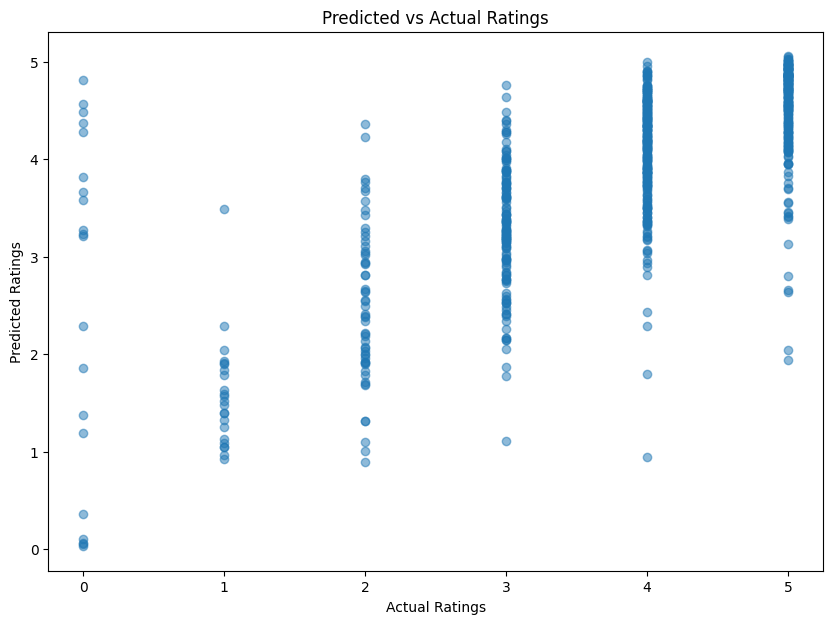

In [4]:
# Predicted vs actual ratings
plt.figure(figsize=(10, 7))
plt.scatter(df['rating'], df['predicted_rating'], alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

### **As we can see, the model shows a good accuracy. We can see that the model is still very confused with the "0 ratings". By training the LLM for more epochs, this problem might disapear. It can be better visualized in the following graph:**

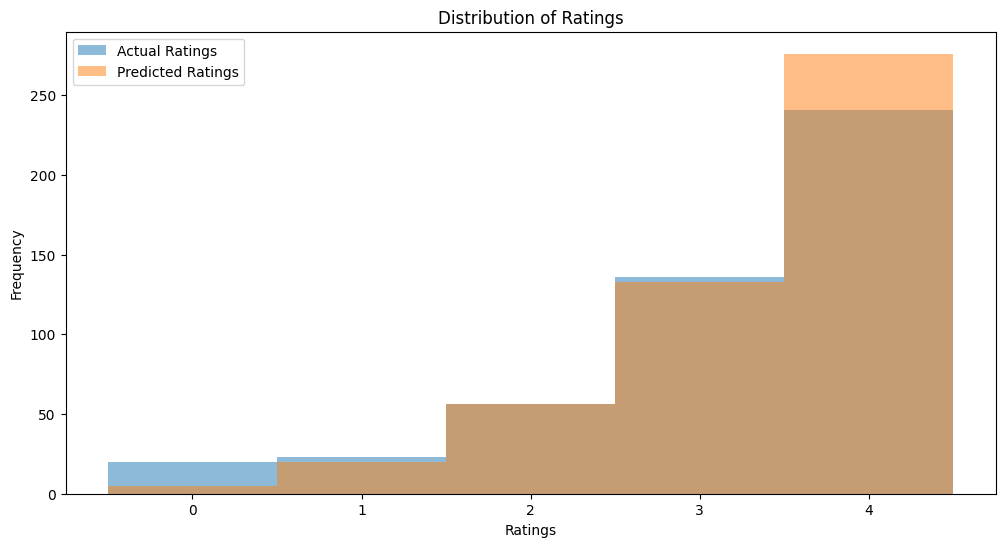

In [5]:
# Ratings distribution
plt.figure(figsize=(12, 6))
plt.hist(df['rating'], bins=np.arange(-0.5, 5.5, 1), alpha=0.5, label='Actual Ratings')
plt.hist(df['predicted_rating'], bins=np.arange(-0.5, 5.5, 1), alpha=0.5, label='Predicted Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.legend()
plt.show()

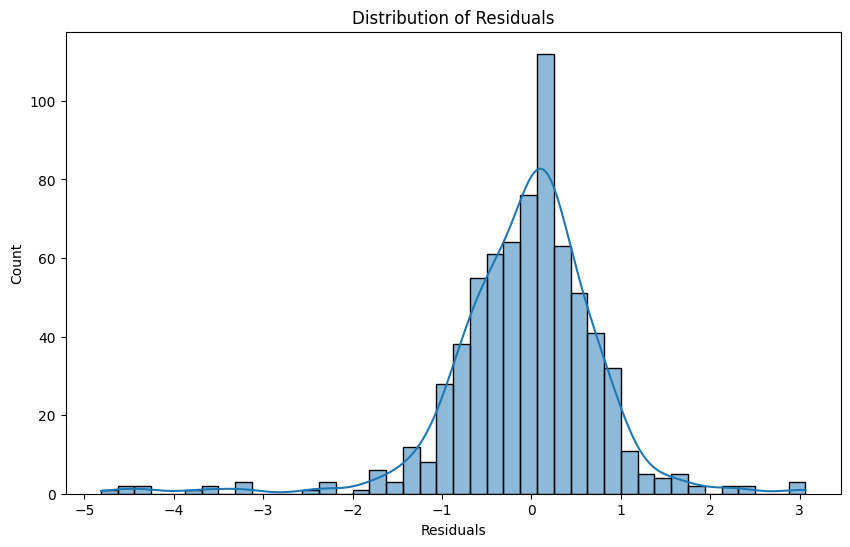

In [6]:
# Residuals
residuals = df['rating'] - df['predicted_rating']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

### **The residuals are mostly centered around zero, with a slight skew to the negative side, indicating that the model tends to slightly overestimate ratings in some cases. The distribution appears roughly normal, suggesting a reasonable fit overall.**

In [7]:
# Misclassified examples (high residuals)
threshold = residuals.abs().quantile(0.95)
high_residuals = df[residuals.abs() > threshold]
print(f"Number of high residual examples: {len(high_residuals)}")
if len(high_residuals) > 0:
    print(high_residuals[['review_text', 'rating', 'predicted_rating']].head(5))


Number of high residual examples: 35
                                              review_text  rating  \
96398   Three and a half stars, -ish ... my reaction t...       0   
34965   Sagan is always a good read. His brilliance is...       5   
34257   I stumbled across this while searching for som...       0   
142821  The author imagines the story and the human be...       3   
95047   It's probably not fair of me to mark this as "...       3   

        predicted_rating  
96398           3.229551  
34965           3.382152  
34257           2.284896  
142821          4.639032  
95047           1.112587  
